In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import os
from keras.applications.resnet50 import ResNet50,decode_predictions,preprocess_input
from keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil

Using TensorFlow backend.


In [2]:
trainPATH='all/train/'
img_train=os.listdir(trainPATH)
print("No of trainable images="+str(len(img_train)))

No of trainable images=10222


In [3]:
f=open('all/labels.csv')
label=pd.read_csv(f)
label.head()
# label['id'][0]
# label.shape

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
#MAKE DATA TO BE IN PROPER DIRECTORIES(DIRECTORY FOR EACH CLASS)
breeds=[]
import pathlib
# pathlib.Path('/my/directory').mkdir(parents=True, exist_ok=True)
for i in range(label.shape[0]):
    if not os.path.exists(label['breed'][i]):
        breeds.append(label['breed'][i])
        os.makedirs(label['breed'][i])
    shutil.copy(trainPATH+label['id'][i]+'.jpg',label['breed'][i]+'/')
files=os.listdir()
os.makedirs('x_train')
for i in range(len(files)):
    if files[i] in breeds and files[i] not in  os.listdir('x_train/'):
        shutil.move(files[i],'x_train/')

In [6]:
len(breeds)

120

In [7]:
testPATH='all/test/'
img_test=os.listdir(testPATH)
print("No of test images="+str(len(img_test)))

No of test images=10357


(388, 370, 3)

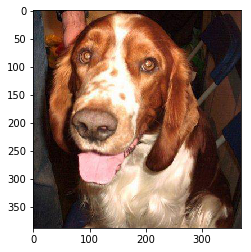

In [8]:
img=load_img(trainPATH+img_train[6])
plt.imshow(img)
img=img_to_array(img)
img.shape

In [9]:
bottom_model=ResNet50(include_top=False,input_shape=(224,224,3))

In [10]:
bottom_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [22]:
# Freeze the layers except the last 4 layers
for layer in bottom_model.layers[:]:
    layer.trainable = False
# for layer in bottom_model.layers[:]:
#     layer.trainable = True
# check the trainable status of the individual layers
for layer in bottom_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4c492b95f8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f4c492b97b8> False
<keras.layers.convolutional.Conv2D object at 0x7f4c492b9400> False
<keras.layers.normalization.BatchNormalization object at 0x7f4c492b9d30> False
<keras.layers.core.Activation object at 0x7f4c492b9908> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4c44392dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f4c456332e8> False
<keras.layers.normalization.BatchNormalization object at 0x7f4c443ae0b8> False
<keras.layers.core.Activation object at 0x7f4c44375c88> False
<keras.layers.convolutional.Conv2D object at 0x7f4c442cd198> False
<keras.layers.normalization.BatchNormalization object at 0x7f4c44285b70> False
<keras.layers.core.Activation object at 0x7f4c4429f278> False
<keras.layers.convolutional.Conv2D object at 0x7f4c4422d860> False
<keras.layers.convolutional.Conv2D object at 0x7f4c44184908> False
<keras.layers.normalization.Batc

In [23]:
bottom_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [26]:
#Adding Top Layers to classify between cat and dog

from keras import Sequential
from keras.layers import Flatten,Dense,Dropout,BatchNormalization
model=Sequential()
model.add(bottom_model)
model.add(Flatten(input_shape=bottom_model.output_shape))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(120,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25690368  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               30840     
Total params: 49,309,944
Trainable params: 25,721,720
Non-trainable params: 23,588,224
_______________________________________________________

In [27]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
# Change the batchsize according to system RAM/GPU
train_batchsize = 100
image_size=224 
train_dir='x_train/'
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        classes=breeds,
        class_mode='categorical')

Found 10222 images belonging to 120 classes.


In [29]:
from keras import optimizers
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.save('compiled_model')

In [31]:
with tf.device("/device:GPU:0"):
    model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    epochs=1)
model.save_weights('dogsbreed.h5')

Epoch 1/1
  7/102 [=>............................] - ETA: 1:09:53 - loss: 0.0536 - acc: 0.9915

KeyboardInterrupt: 